# Custom Training with YOLOv5

In this project, we assemble a dataset and train a custom YOLOv5 model to recognize the score in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work


#Install Requirements

In [1]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow


Cloning into 'yolov5'...
remote: Enumerating objects: 14806, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 14806 (delta 78), reused 96 (delta 50), pack-reused 14669
Receiving objects: 100% (14806/14806), 13.63 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (10215/10215), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 45.5 MB/s 
     |████████████████████████████████| 41 kB 202 kB/s 
     |████████████████████████████████| 138 kB 64.4 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 178 kB 68.4 MB/s 
     |████████████████████████████████| 145 kB 70.4 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 


In [2]:
#clone augmentation class
!git clone https://github.com/gpurci/ImageAugmentation

Cloning into 'ImageAugmentation'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


#Install Library

In [3]:
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


In [4]:
# importing cv2 
import cv2
from matplotlib import pyplot as plt
from numpy.fft import fft2, ifft2
import math
import numpy as np
import pandas as pd
import shutil
from roboflow import Roboflow

In [5]:
#import augmentation class
from ImageAugmentation.image_augmentation import AugmentImage

# Assemble Dataset

In order to train our custom model, we need to assemble a dataset of representative images with bounding box annotations around the scores that we want to detect. And we need our dataset to be in YOLOv5 format.

In Roboflow, we can choose between two paths:

* Convert an existing dataset to YOLOv5 format. Roboflow supports over [30 formats object detection formats](https://roboflow.com/formats) for conversion.
* Upload raw images and annotate them in Roboflow with [Roboflow Annotate](https://docs.roboflow.com/annotate).



In [13]:
def dowAugmentedImage():
  rf = Roboflow(model_format="yolov5", notebook="ultralytics")
  #after following the link above, recieve python code with these fields filled in
  rf = Roboflow(api_key="L74r4HoRJrzqgK7mAWKk")
  # set up environment
  os.environ["DATASET_DIRECTORY"] = "/content/datasets"
  #get project digitalizare_note from roboflow
  project = rf.workspace().project("digitalizare_note")
  #get first version project
  dataset = project.version("1")
  #dowloand augmented data
  dataset = dataset.download("yolov5")
  return dataset

In [29]:
try:
    shutil.rmtree('/content/yolov5/runs')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
''' '''

' '

In [17]:
dataset = dowAugmentedImage()

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/digitalizare_note-1 in yolov5pytorch:: 100%|██████████| 46/46 [00:00<00:00, 4848.66it/s]


#Image augmentation

##Data manipulation

In [18]:
aug_img  = AugmentImage()
aug_img.setRotationAngel(-5., 5.)

In [19]:
def find_file_by_ext(path, ext):
  dict_data = {}
  for root, dirs, files in os.walk(path):
    for file in files:
      if file.endswith(ext):
        dict_data[os.path.splitext(file)[0]] = root
  return dict_data

def roboflow_data_augmentation(path, nbr_gen_for_sample):
  dict_data_f = find_file_by_ext(path, '.jpg')
  dict_data_t = find_file_by_ext(path, '.txt')
  pd_df_data = pd.DataFrame({'F':dict_data_f, 'T':dict_data_t})
  
  size_ = pd_df_data.shape[0]
  for i in range(size_):
    for j in range(i*nbr_gen_for_sample, (i+1)*nbr_gen_for_sample):
      name_ = pd_df_data.index[i].split('.')[0]

      src_t = '{}/{}{}'.format(pd_df_data['T'][i], pd_df_data.index[i], '.txt')
      dst_t = '{}/{}_gen_{}{}'.format(pd_df_data['T'][i], name_, j, '.txt')

      src_f = '{}/{}{}'.format(pd_df_data['F'][i], pd_df_data.index[i], '.jpg')
      dst_f = '{}/{}_gen_{}{}'.format(pd_df_data['F'][i], name_, j, '.jpg')
      #print('Target  src {}\nTarget  dst {}'.format(src_t, dst_t))
      #print('Feature src {}\nFeature dst {}'.format(src_f, dst_f))
      lst_generated_file.append(dst_t)
      lst_generated_file.append(dst_f)
      shutil.copy(src_t, dst_t)
      np_img = np.array(cv2.imread(src_f, cv2.IMREAD_COLOR))
      idx_img_gen = np.random.randint(low=0, high=3, size=1)[0]
      np_gen_img = aug_img.getAugmentFunc(idx_img_gen)(np_img)
      cv2.imwrite(dst_f, np_gen_img)


In [ ]:
def removeFile(_lst_file):
  for filename in _lst_file:
    if os.path.exists(filename):
      os.remove(filename)
    else:
      print("The file {} does not exist".format(filename))

In [ ]:
removeFile(lst_generated_file)
del lst_generated_file

The file /content/datasets/digitalizare_note-1/test/images/20201104_175030_jpg_gen_71.jpg does not exist


In [21]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/test"
nbr_gen_for_sample = 300
roboflow_data_augmentation(path, nbr_gen_for_sample)

In [11]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/train"
nbr_gen_for_sample = 400
roboflow_data_augmentation(path, nbr_gen_for_sample)

In [12]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/valid"
nbr_gen_for_sample = 300
roboflow_data_augmentation(path, nbr_gen_for_sample)

# Train YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

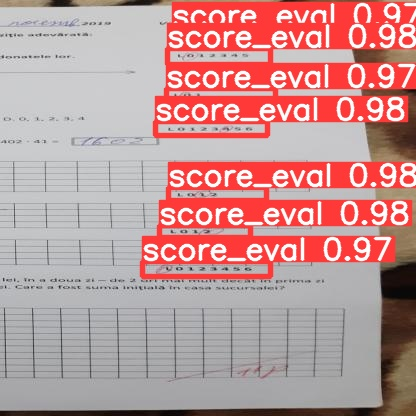

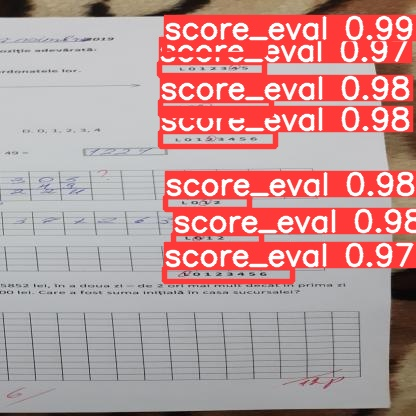

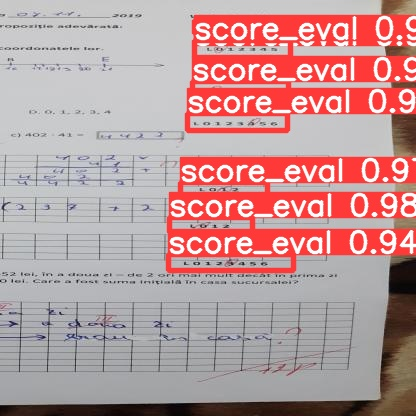

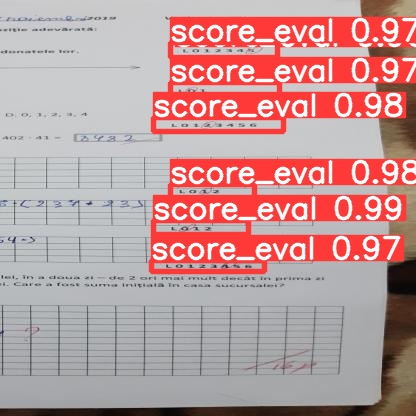

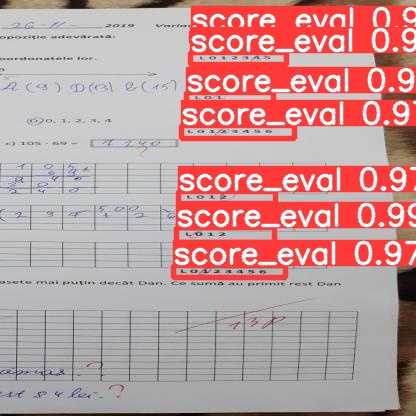

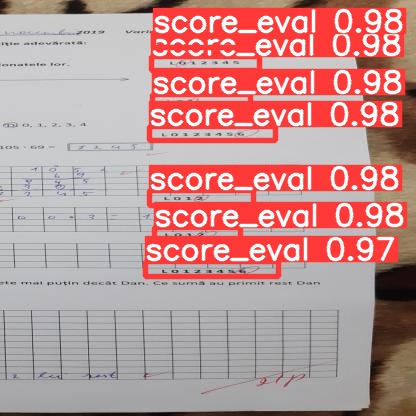

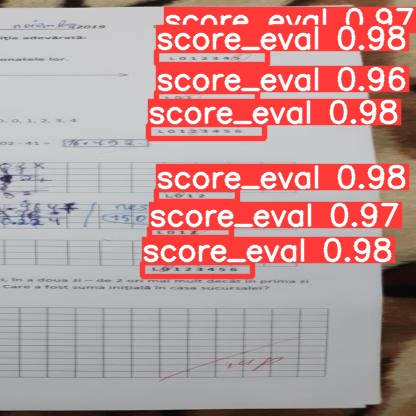

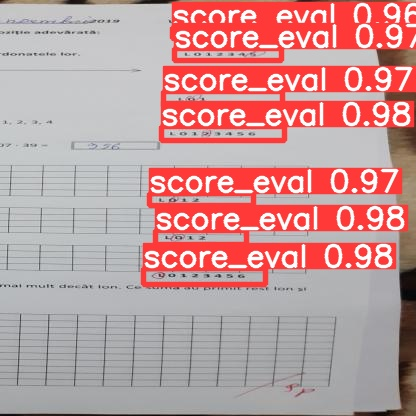

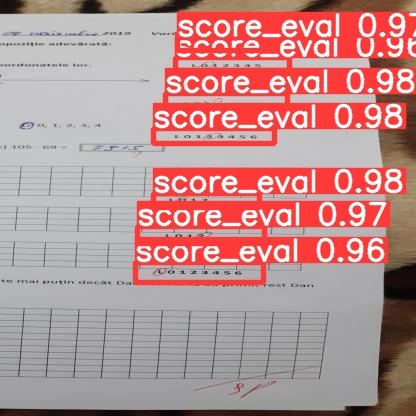

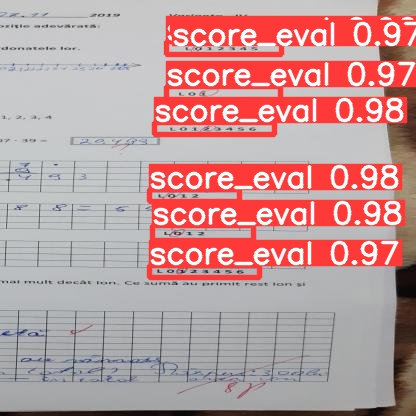

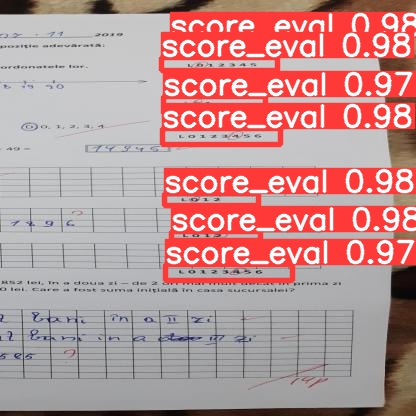

In [31]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    img = Image(filename=imageName)
    display(img)
    print("\n")

In [ ]:
#export model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>